In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore
from matplotlib.colors import Normalize


In [2]:
from sklearn.cross_decomposition import PLSRegression
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [5]:
format_plots()

In [6]:
## arrange data
keep_syllables = np.loadtxt('to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

# avarage per age or session
m_df = male_df.groupby(['age', 'uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [7]:
def pgl(df, ax, cmm):
    age_pc_pls = df.groupby('age').mean()
    # Convert to DataFrame for easier rolling operation
    df_pls = pd.DataFrame(age_pc_pls)

    # Apply rolling window average for PLS
    window_size = 2  # Adjust the window size as needed
    df_smooth_pls = df_pls.rolling(window=window_size, min_periods=1, center=True).mean()

    # Create segments for LineCollection from the smoothed data for PLS
    points_pls = np.array([df_smooth_pls['dim1'], df_smooth_pls['dim2']]).T.reshape(-1, 1, 2)
    segments_pls = np.concatenate([points_pls[:-1], points_pls[1:]], axis=1)

    # Create the line collection object for PLS
    lc_pls = LineCollection(segments_pls, cmap=cmm, norm=plt.Normalize(0, 1), linewidth=1)
    lc_pls.set_array(np.linspace(0, 1, len(df_smooth_pls['dim1'])))

    # Create the outer black line collection for PLS
    black_lc_pls = LineCollection(segments_pls, colors='black', linewidth=2)

    # Add the black line collection to the plot for PLS
    ax.add_collection(black_lc_pls)

    # Add line collection to the plot for PLS
    ax.add_collection(lc_pls)
    ax.autoscale()

## PLS regression

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

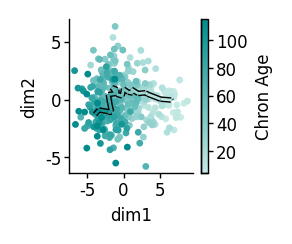

In [8]:
#df = m_norm.copy()
df=m_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1,1))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_pls, ax=ax, cmm=cmm)

# Add color bar
norm = plt.Normalize(vmin=pcs_pls['age'].min(), vmax=pcs_pls['age'].max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Create color bar and set ticks
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Chron Age')
cbar.set_ticks([20, 40, 60, 80,100])
cbar.set_ticklabels([20, 40, 60, 80, 100])

sns.despine()
plt.show()

In [9]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_17_PLS_embedding_male_raw_smooth=2.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

In [10]:
## female

In [11]:
## arrange data for females
keep_syllables = np.loadtxt('to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [12]:
# avarage per age or session
f_df = f_df.sort_index(level='age')
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# zscore
z_f = f_df.apply(zscore, axis=0)
avg_z_f = avg_f_df.apply(zscore, axis=0)

# log
f_log = np.log(f_df+1e-3)
avg_f_log = np.log(avg_f_df+1e-3)

# log and z_score
z_log = f_log.apply(zscore, axis=0)
avg_z_log = avg_f_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_f = (
    avg_f_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## PLS regression

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

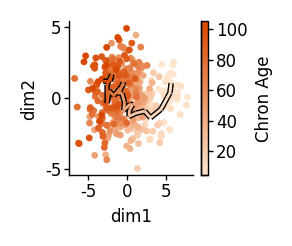

In [13]:
#df = m_norm.copy()
df=f_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
age_pc_pls = pcs_pls.groupby('age').mean()


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1,1))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmf, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_pls, ax=ax, cmm=cmf)

# Add color bar
norm = plt.Normalize(vmin=pcs_pls['age'].min(), vmax=pcs_pls['age'].max())
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Create color bar and set ticks
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Chron Age')
cbar.set_ticks([20, 40, 60, 80,100])
cbar.set_ticklabels([20, 40, 60, 80, 100])
sns.despine()
plt.show()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_17_PLS_embedding_female_raw_smooth=2.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

In [15]:
## joint

In [16]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [17]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)
data=pd.concat([m_data,f_data])

/tmp/ipykernel_30471/3374632765.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_30471/3374632765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [18]:
data=pd.concat([m_data,f_data])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

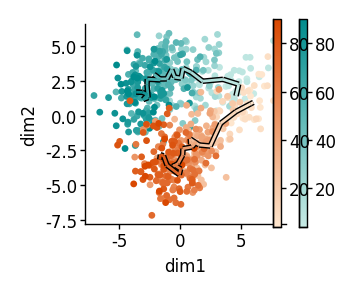

In [19]:
#df = m_norm.copy()
df=data.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
pcs_pls['sex'] = df.index.get_level_values('sex')

fig, ax = plt.subplots(figsize=(1.3,1.3))

#get and plot the male data
pcs_male = pcs_pls.query('sex=="m"').drop(columns=['sex'])
sns.scatterplot(data=pcs_male, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_male, ax, cmm)


# Add color bar for male data
norm_male = Normalize(vmin=pcs_male['age'].min(), vmax=pcs_male['age'].max())
sm_male = plt.cm.ScalarMappable(cmap=cmm, norm=norm_male)
sm_male.set_array([])

# Position color bar for male data
cbar_ax_male = fig.add_axes([0.95, 0.1, 0.03, 0.80])  # [left, bottom, width, height]
cbar_male = fig.colorbar(sm_male, cax=cbar_ax_male)
cbar_male.set_ticks([20, 40, 60, 80])
cbar_male.set_ticklabels([20, 40, 60, 80])

#get and plot the female data
pcs_female = pcs_pls.query('sex=="f"').drop(columns=['sex'])
sns.scatterplot(data=pcs_female, x='dim1', y='dim2', hue='age', palette=cmf, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_female, ax, cmf)

# Add color bar for female data
norm_female = Normalize(vmin=pcs_female['age'].min(), vmax=pcs_female['age'].max())
sm_female = plt.cm.ScalarMappable(cmap=cmf, norm=norm_female)
sm_female.set_array([])

# Position color bar for female data
cbar_ax_female = fig.add_axes([0.85, 0.1, 0.03, 0.80])  # [left, bottom, width, height]
cbar_female = fig.colorbar(sm_female, cax=cbar_ax_female)
cbar_female.set_ticks([20, 40, 60, 80])
cbar_female.set_ticklabels([20, 40, 60, 80])

sns.despine()
plt.show()

In [20]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_25_PLS_regression_fvm.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f